# Imports + Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from helper_methods import *

plt.rcParams.update({
    'figure.figsize':(11,7), 
    'figure.dpi':120
})
image_dest = 'results_images/'
visual_specs={'fontsize':14, 'palette':'Greys', 'saturation':0.5}
fontsize = visual_specs['fontsize']
palette = visual_specs['palette']
datapath = '../Data/'

id_col = 'SPA_PER_ID'
event_col = 'CMIS_MATCH'

# Load Predictions

In [2]:
def load_model_output(filepath: str):
    infile = open(filepath, 'rb')
    model_output = pickle.load(infile)
    infile.close()
    return model_output['Performance'], model_output['Models'], model_output['Features'] #, model_output['Data_Retention_Stats']

In [3]:
"""filename = 'output_00.pickle'
summary, models, features, data_retention_stats = load_model_output(datapath+filename)

print(filename + ' Features')
print_list(features)
print(filename + ' Data Retention Stats')
print_dict(data_retention_stats)"""

"filename = 'output_00.pickle'\nsummary, models, features, data_retention_stats = load_model_output(datapath+filename)\n\nprint(filename + ' Features')\nprint_list(features)\nprint(filename + ' Data Retention Stats')\nprint_dict(data_retention_stats)"

In [4]:
filename = 'output0.pickle'
summary, models, features = load_model_output(datapath+filename)

print(filename + ' Features')
print_list(features)

output0.pickle Features
PAST_DUE
TOTAL_CUR_BALANCE
NUM_PREM_FOR_PER
BREAK_ARRANGEMENT
NUM_PER_FOR_PREM
PER-PREM-MONTH_ID
CMIS_MATCH


# ROC Curve

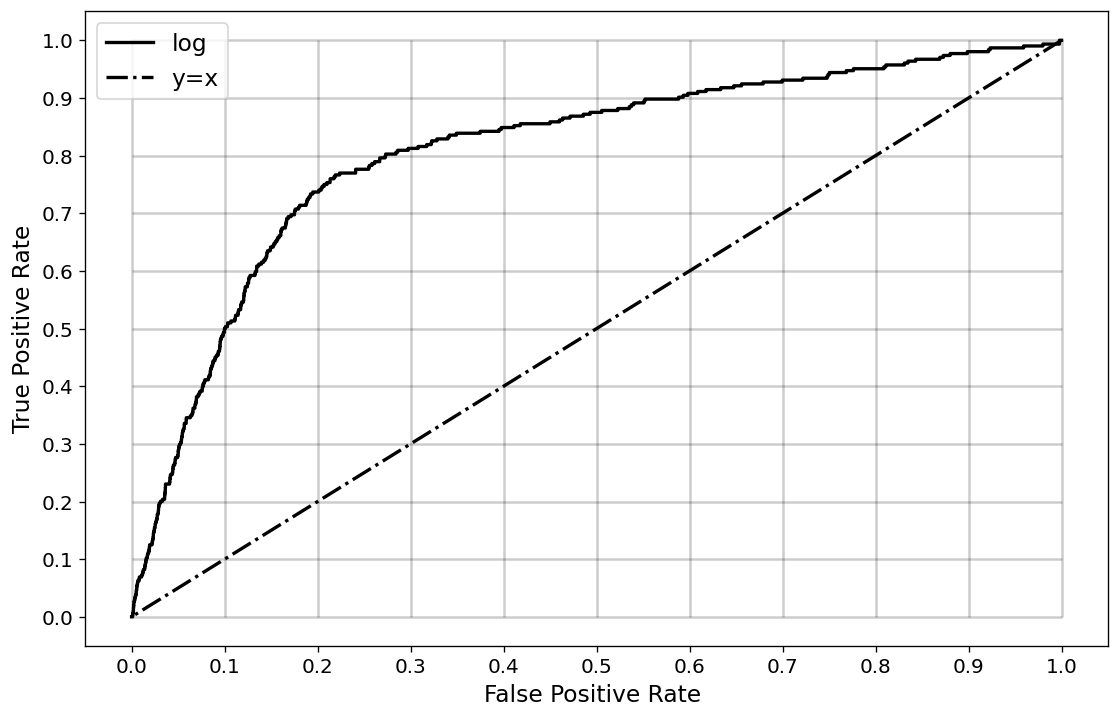

In [5]:
linewidth = 2
color = 'black'
alpha=0.2

plt.plot(summary['fpr'], summary['tpr'], color='black', label='log', linestyle='-', linewidth=linewidth)

# Refernce line
plt.plot([1, 0], [1, 0], color='black', label='y=x', linestyle='dashdot', linewidth=linewidth)

ticks = np.arange(0, 1.1, 0.1)
plt.hlines(y=ticks, xmin=0, xmax=1, colors=color, alpha=alpha)
plt.vlines(x=ticks, ymin=0, ymax=1, colors=color, alpha=alpha)
plt.xlabel('False Positive Rate ', fontsize=fontsize)
plt.xticks(ticks, fontsize=fontsize-2)
plt.ylabel('True Positive Rate', fontsize=fontsize)
plt.yticks(ticks, fontsize=fontsize-2)
plt.legend(fontsize=fontsize)
# plt.savefig(fname=image_dest+'ROC.png', bbox_inches='tight')
plt.show()

# Analyze Models

In [6]:
float_format = "%.3f"
features_to_drop = ['PER-PREM-MONTH_ID', 'CMIS_MATCH']
xname = [x for x in features if x not in features_to_drop]

In [7]:
def avg_params(models, xname):
    params = np.zeros(shape=len(xname))
    conf_int = np.zeros(shape=(len(xname), 2))
    k = len(models)
    for model in models:
        params = np.add(params, model.params)
        conf_int = np.add(conf_int, model.conf_int())
    params = np.divide(params, k)
    conf_int = np.divide(conf_int, k)
    df = pd.DataFrame(data={'Feature': xname,
                            'Mean Coeff': params,
                            'Mean OR': np.exp(params),
                            'Mean [0.025': np.exp(conf_int[:, 0]),
                            'Mean 0.975]': np.exp(conf_int[:, 1])})
    return df

In [8]:
avg_params = avg_params(models=models, xname=xname)

print(avg_params.to_latex(float_format=float_format, index=False))

\begin{tabular}{lrrrr}
\toprule
          Feature &  Mean Coeff &  Mean OR &  Mean [0.025 &  Mean 0.975] \\
\midrule
         PAST\_DUE &       0.338 &    1.403 &        1.391 &        1.415 \\
TOTAL\_CUR\_BALANCE &       0.000 &    1.000 &        1.000 &        1.000 \\
 NUM\_PREM\_FOR\_PER &      -6.914 &    0.001 &        0.001 &        0.001 \\
BREAK\_ARRANGEMENT &       0.591 &    1.807 &        1.635 &        1.997 \\
 NUM\_PER\_FOR\_PREM &       0.105 &    1.111 &        1.060 &        1.165 \\
\bottomrule
\end{tabular}



# Analyze Performance

In [9]:
reporting_metrics = ['threshold', 'tpr', 'fpr', 'ppv', 'accuracy', 'balanced', 'f-1']
print(f'AUC: {summary["auc"].loc[0]}')

AUC: 0.8082001604245079


## Compare to Shinn's 2013 Study: TPR = 71.6%

In [10]:
delta = 0.002
tpr_target = 0.716

print(summary[abs(summary['tpr'] - tpr_target) < delta][reporting_metrics].
      to_latex(float_format=float_format, index=False))

\begin{tabular}{rrrrrrr}
\toprule
 threshold &   tpr &   fpr &   ppv &  accuracy &  balanced &   f-1 \\
\midrule
     0.002 & 0.717 & 0.188 & 0.717 &     0.812 &     0.765 & 0.717 \\
     0.002 & 0.717 & 0.188 & 0.717 &     0.811 &     0.764 & 0.717 \\
\bottomrule
\end{tabular}



## Compare to Byrne's 2020 study: TPR = 77.8%

In [11]:
delta = 0.0025
tpr_target = 0.778

print(summary[abs(summary['tpr'] - tpr_target) < delta][reporting_metrics].
      to_latex(float_format=float_format, index=False))

\begin{tabular}{rrrrrrr}
\toprule
 threshold &   tpr &   fpr &   ppv &  accuracy &  balanced &   f-1 \\
\midrule
     0.002 & 0.776 & 0.241 & 0.776 &     0.759 &     0.768 & 0.776 \\
     0.002 & 0.776 & 0.243 & 0.776 &     0.757 &     0.766 & 0.776 \\
     0.002 & 0.776 & 0.244 & 0.776 &     0.757 &     0.766 & 0.776 \\
     0.002 & 0.776 & 0.247 & 0.776 &     0.753 &     0.765 & 0.776 \\
     0.002 & 0.776 & 0.247 & 0.776 &     0.753 &     0.765 & 0.776 \\
     0.002 & 0.776 & 0.249 & 0.776 &     0.751 &     0.764 & 0.776 \\
     0.002 & 0.776 & 0.249 & 0.776 &     0.751 &     0.764 & 0.776 \\
     0.002 & 0.776 & 0.251 & 0.776 &     0.749 &     0.763 & 0.776 \\
     0.002 & 0.776 & 0.251 & 0.776 &     0.749 &     0.763 & 0.776 \\
     0.002 & 0.776 & 0.253 & 0.776 &     0.748 &     0.762 & 0.776 \\
     0.002 & 0.776 & 0.253 & 0.776 &     0.748 &     0.762 & 0.776 \\
     0.002 & 0.776 & 0.253 & 0.776 &     0.747 &     0.761 & 0.776 \\
     0.002 & 0.776 & 0.254 & 0.776 &     0.747 

## Compare to VanBerlo's 2020 study: TPR = 92.1%

In [12]:
delta = 0.0005
tpr_target = 0.921

print(summary[abs(summary['tpr'] - tpr_target) < delta][reporting_metrics].
      to_latex(float_format=float_format, index=False))

\begin{tabular}{rrrrrrr}
\toprule
 threshold &   tpr &   fpr &   ppv &  accuracy &  balanced &   f-1 \\
\midrule
     0.001 & 0.921 & 0.648 & 0.921 &     0.355 &     0.637 & 0.921 \\
     0.001 & 0.921 & 0.648 & 0.921 &     0.354 &     0.637 & 0.921 \\
     0.001 & 0.921 & 0.648 & 0.921 &     0.354 &     0.637 & 0.921 \\
     0.001 & 0.921 & 0.648 & 0.921 &     0.354 &     0.637 & 0.921 \\
     0.001 & 0.921 & 0.648 & 0.921 &     0.354 &     0.637 & 0.921 \\
     0.001 & 0.921 & 0.648 & 0.921 &     0.354 &     0.637 & 0.921 \\
     0.001 & 0.921 & 0.648 & 0.921 &     0.354 &     0.637 & 0.921 \\
     0.001 & 0.921 & 0.648 & 0.921 &     0.354 &     0.637 & 0.921 \\
     0.001 & 0.921 & 0.648 & 0.921 &     0.354 &     0.637 & 0.921 \\
     0.001 & 0.921 & 0.648 & 0.921 &     0.354 &     0.636 & 0.921 \\
     0.001 & 0.921 & 0.648 & 0.921 &     0.354 &     0.636 & 0.921 \\
     0.001 & 0.921 & 0.649 & 0.921 &     0.353 &     0.636 & 0.921 \\
     0.001 & 0.921 & 0.649 & 0.921 &     0.353 

## At TPR = 90.0%

In [13]:
delta = 0.002
tpr_target = 0.90

print(summary[abs(summary['tpr'] - tpr_target) < delta][reporting_metrics].
      to_latex(float_format=float_format, index=False))

\begin{tabular}{rrrrrrr}
\toprule
 threshold &   tpr &   fpr &   ppv &  accuracy &  balanced &   f-1 \\
\midrule
     0.001 & 0.898 & 0.552 & 0.898 &     0.450 &     0.673 & 0.898 \\
     0.001 & 0.898 & 0.552 & 0.898 &     0.449 &     0.673 & 0.898 \\
     0.001 & 0.898 & 0.552 & 0.898 &     0.449 &     0.673 & 0.898 \\
     0.001 & 0.898 & 0.553 & 0.898 &     0.449 &     0.673 & 0.898 \\
     0.001 & 0.898 & 0.553 & 0.898 &     0.449 &     0.673 & 0.898 \\
     0.001 & 0.898 & 0.553 & 0.898 &     0.449 &     0.673 & 0.898 \\
     0.001 & 0.898 & 0.553 & 0.898 &     0.449 &     0.673 & 0.898 \\
     0.001 & 0.898 & 0.553 & 0.898 &     0.449 &     0.673 & 0.898 \\
     0.001 & 0.898 & 0.553 & 0.898 &     0.449 &     0.673 & 0.898 \\
     0.001 & 0.898 & 0.553 & 0.898 &     0.449 &     0.673 & 0.898 \\
     0.001 & 0.898 & 0.553 & 0.898 &     0.449 &     0.672 & 0.898 \\
     0.001 & 0.898 & 0.554 & 0.898 &     0.447 &     0.672 & 0.898 \\
     0.001 & 0.898 & 0.554 & 0.898 &     0.447 

## Threshold = 0.5

In [14]:
delta = 0.15
threshold_target = 0.5

print(summary[abs(summary['threshold'] - threshold_target) < delta][reporting_metrics].
      to_latex(float_format=float_format, index=False))

\begin{tabular}{rrrrrrr}
\toprule
Empty DataFrame
Columns: Index(['threshold', 'tpr', 'fpr', 'ppv', 'accuracy', 'balanced', 'f-1'], dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

